In [1]:
from __future__ import print_function
import torch, os, gym, time, glob, argparse, sys
import numpy as np
from scipy.signal import lfilter
from scipy.misc import imresize # preserves single-pixel info _unlike_ img = img[::2,::2]
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import collections
os.environ['OMP_NUM_THREADS'] = '1'

import time

# The Saliency Predictor

In [2]:
class GazeNetwork(nn.Module):
  def __init__(self):
    super(GazeNetwork, self).__init__()
    self.conv1 = nn.Conv2d(4, 32, 4, stride=2, bias = True)
    self.conv2 = nn.Conv2d(32, 64, 3, stride=2, bias = True)
    self.conv3 = nn.Conv2d(64, 64, 5, stride=2, bias = True)
    self.deconv3 = nn.ConvTranspose2d(64,64,5,stride = 2, bias = True)
    self.deconv2 = nn.ConvTranspose2d(64,32,3,stride = 2, bias = True)
    self.deconv1 = nn.ConvTranspose2d(32,1,4,stride = 2, bias = True)
    self.logsoftmax = nn.LogSoftmax(dim = -1)
    
  def forward(self, X, train=True, hard=False):
    X = F.elu(self.conv1(X))
    X = F.elu(self.conv2(X))
    X = F.elu(self.conv3(X))
    X = F.elu(self.deconv3(X))
    X = F.elu(self.deconv2(X))
    X = self.deconv1(X)
    
    return self.logsoftmax(X.view(-1,1,6400)).view(-1,1,80,80)
  
  def load_model(self, path):
    self.load_state_dict(torch.load(path))

In [3]:
gazenet = GazeNetwork()#.train(False)
gazenet.load_model('model/saliency_model_5.tar')

----

Make  the policy trainer.

In [4]:
def get_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('--env', default='Pong-v4', type=str, help='gym environment')
    parser.add_argument('--processes', default=20, type=int, help='number of processes to train with')
    parser.add_argument('--render', default=False, type=bool, help='renders the atari environment')
    parser.add_argument('--test', default=False, type=bool, help='sets lr=0, chooses most likely actions')
    parser.add_argument('--rnn_steps', default=50, type=int, help='steps to train LSTM over')
    parser.add_argument('--lr', default=0.0001, type=float, help='learning rate')
    parser.add_argument('--seed', default=1, type=int, help='seed random # generators (for reproducibility)')
    parser.add_argument('--gamma', default=0.99, type=float, help='rewards discount factor')
    parser.add_argument('--tau', default=1.0, type=float, help='generalized advantage estimation discount')
    parser.add_argument('--horizon', default=0.8, type=float, help='horizon for running averages')
    parser.add_argument('--hidden', default=32, type=int, help='hidden size of GRU')
    return parser.parse_args([])

In [5]:
discount = lambda x, gamma: lfilter([1],[1,-gamma],x[::-1])[::-1] # discounted rewards one liner
prepro = lambda img: imresize(img[35:195].mean(2), (80,80)).astype(np.float32)/255.

def get_saliency(states, net= gazenet):
  sal = net(torch.FloatTensor(states).view(1,4,80,80))
  sal = sal.data.numpy()
  sal = np.exp(sal)
  sal = sal/sal.max()
  sal = np.minimum(sal,.1)
  return torch.tensor(np.multiply(sal, states[-1]))
  
def printlog(args, s, end='\n', mode='a'):
    print(s, end=end) ; f=open(args.save_dir+'log.txt',mode) ; f.write(s+'\n') ; f.close()

In [6]:
env = gym.make('Pong-v4')
state = env.reset()
frames = []
seq = collections.deque(maxlen = 4)
for _ in range(4):
  seq.append(np.zeros((80,80)))

state = prepro(state)
seq.append(state)
for i in range(50):
  action = np.random.randint(6)
  frame, reward, done, _ = env.step(action)
  
  state = prepro(frame)
  seq.append(state)
  state_sal = get_saliency(seq)
  frames.append(state_sal)
  

/usr/local/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [7]:
frames[0].shape

torch.Size([1, 1, 80, 80])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


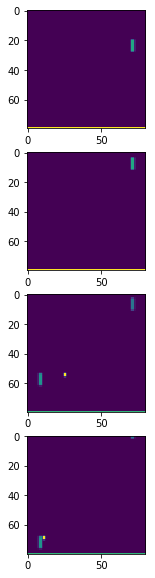

In [8]:
import matplotlib.pyplot as plt
% matplotlib inline
fig, ax = plt.subplots(nrows = 4, figsize = (20,10))

print(frames[10].data.numpy()[0,0,10,:])
for i in range(1,5):
  ax[i-1].imshow(frames[i*10].data.numpy()[0,0])

In [9]:
times = []
for _ in range(50):
  start = time.time()

  k = get_saliency(seq)

  times.append(time.time()-start)
26000*np.mean(times)/60

3.0644116401672363

In [10]:
class NNPolicy(nn.Module): # an actor-critic neural network
    def __init__(self, num_actions, channels, memsize):
        super(NNPolicy, self).__init__()
        self.conv1 = nn.Conv2d(channels, 4, 3, stride=2, padding=1, bias = None)
        self.conv2 = nn.Conv2d(4, 8, 3, stride=2, padding=1, bias = None)
        self.conv3 = nn.Conv2d(8, 16, 5, stride=4, padding=2, bias = None)
        self.conv4 = nn.Conv2d(16, 32, 3, stride=2, padding=1, bias = None)
        self.conv5 = nn.Conv2d(32, 64, 3, stride=1, padding=0, bias = None)
        self.mem = nn.LSTMCell(64, memsize, bias = None)
        self.critic_linear, self.actor_linear = nn.Linear(memsize, 1, bias = None), nn.Linear(memsize, num_actions, bias = None)

    def forward(self, inputs, train=True, hard=False):
        inp, hx, cx = inputs
        x = F.elu(self.conv1(inp))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        hx, cx = self.mem(x.view(-1, 64 * 1 * 1), (hx, cx))
        return self.critic_linear(hx), self.actor_linear(hx), hx, cx

    def try_load(self, save_dir):
        paths = glob.glob(save_dir + '*.tar') ; step = 0
        if len(paths) > 0:
            ckpts = [int(s.split('.')[-2]) for s in paths]
            ix = np.argmax(ckpts) ; step = ckpts[ix]
            self.load_state_dict(torch.load(paths[ix]))
        print("\tno saved models") if step is 0 else print("\tloaded model: {}".format(paths[ix]))
        return step

In [11]:
model = NNPolicy(6,1,32)
count = 0
for f in model.parameters():
  count += np.prod(f.size())
  print(f.size(), np.prod(f.size()))
  
count

torch.Size([4, 1, 3, 3]) 36
torch.Size([8, 4, 3, 3]) 288
torch.Size([16, 8, 5, 5]) 3200
torch.Size([32, 16, 3, 3]) 4608
torch.Size([64, 32, 3, 3]) 18432
torch.Size([128, 64]) 8192
torch.Size([128, 32]) 4096
torch.Size([1, 32]) 32
torch.Size([6, 32]) 192


39076

In [12]:
env = gym.make('Pong-v4')

In [13]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [14]:
32*16*3*3

4608

In [15]:
def cost_func(args, values, logps, actions, rewards):
    np_values = values.view(-1).data.numpy()

    # generalized advantage estimation using \delta_t residuals (a policy gradient method)
    delta_t = np.asarray(rewards) + args.gamma * np_values[1:] - np_values[:-1]
    logpys = logps.gather(1, torch.tensor(actions).view(-1,1))
    gen_adv_est = discount(delta_t, args.gamma * args.tau)
    policy_loss = -(logpys.view(-1) * torch.FloatTensor(gen_adv_est.copy())).sum()
    
    # l2 loss over value estimator
    rewards[-1] += args.gamma * np_values[-1]
    discounted_r = discount(np.asarray(rewards), args.gamma)
    discounted_r = torch.tensor(discounted_r.copy(), dtype=torch.float32)
    value_loss = .5 * (discounted_r - values[:-1,0]).pow(2).sum()
    
    entropy_loss = -(-logps * torch.exp(logps)).sum() # encourage lower entropy
    
    return policy_loss + 0.5 * value_loss# + 0.01 * entropy_loss

In [16]:
def train(model, optimizer, args, info, rank = 0):
    env = gym.make(args.env) # make a local (unshared) environment
    
    # seed everything
    #env.seed(args.seed + rank)
    #torch.manual_seed(args.seed + rank) 
    
    #model = NNPolicy(channels=1, memsize=args.hidden, num_actions=args.num_actions) # a local/unshared model
    
    state_seq = collections.deque(maxlen = 4)
    for _ in range(4):
      state_seq.append(np.zeros((80,80)))
    
    state = prepro(env.reset()) # get first state
    state_seq.append(state)
    state_sal = get_saliency(state_seq)

    start_time = last_disp_time = time.time()
    episode_length, epr, eploss, done  = 0, 0, 0, True # bookkeeping

    while info['frames'][0] <= 8e7 or args.test: # openai baselines uses 40M frames...we'll use 80M
        #model.load_state_dict(shared_model.state_dict()) # sync with shared model
        
        hx = torch.zeros(1, args.hidden) if done else hx.detach()  # rnn activation vector
        cx = torch.zeros(1, args.hidden) if done else cx.detach()
          
        values, logps, actions, rewards = [], [], [], [] # save values for computing gradientss

        for step in range(args.rnn_steps):
            episode_length += 1
            
            value, logit, hx, cx = model((state_sal.view(1,1,80,80), hx,cx))
            logp = F.log_softmax(logit, dim=-1)                             
            
            action = torch.exp(logp).multinomial(num_samples=1).data[0]#logp.max(1)[1].data if args.test else
                                         
            state, reward, done, _ = env.step(action.numpy()[0])
            
            if args.render: env.render()

              
            start = time.time()
            state_seq.append(prepro(state))
            state_sal = get_saliency(state_seq)
            
            epr += reward
                                         
            reward = np.clip(reward, -1, 1) # reward
            done = done or episode_length >= 1e4 # don't playing one ep for too long
            
            info['frames'].add_(1)
            num_frames = int(info['frames'].item())
                                         
            if num_frames % 1e6 == 0: # save every 1M frames
                printlog(args, '\n\t{:.0f}M frames: saved model\n'.format(num_frames/1e6))
                torch.save(model.state_dict(), args.save_dir+'model.{:.0f}.tar'.format(num_frames/1e6))

            if done: # update shared data
                info['episodes'] += 1
                interp = 1 if info['episodes'][0] == 1 else 1 - args.horizon
                info['run_epr'].mul_(1-interp).add_(interp * epr)

            if time.time() - last_disp_time > 300: # print info ~ every 5 minute
                elapsed = time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start_time))
                printlog(args, 'time {}, episodes {:.0f}, frames {:.3f}M, mean epr {:.2f}'
                    .format(elapsed, info['episodes'].item(), num_frames/1e6,
                    info['run_epr'].item()))
                last_disp_time = time.time()

            if done: # maybe print info.
                episode_length, epr = 0, 0
                state = torch.tensor(prepro(env.reset()))

            values.append(value) ; logps.append(logp) ; actions.append(action) ; rewards.append(reward)
        
        # add a final state value function for calculating the losses.
        next_value = torch.zeros(1,1) if done else model((state_sal.view(1,1,80,80), hx,cx))[0]
        values.append(next_value.detach())

        loss = cost_func(args, torch.cat(values), torch.cat(logps), torch.cat(actions), np.asarray(rewards))
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 40)
        #
        #for param, shared_param in zip(model.parameters(), shared_model.parameters()):
        #    if shared_param.grad is None: shared_param._grad = param.grad # sync gradients with shared model
        #shared_optimizer.step()

In [17]:
if __name__ == "__main__":
    #if sys.version_info[0] > 2:
    #    mp.set_start_method('spawn') # this must not be in global scope
    #elif sys.platform == 'linux' or sys.platform == 'linux2':
    #    raise "Must be using Python 3 with linux!" # or else you get a deadlock in conv2d
    
    args = get_args()
    args.save_dir = '{}/'.format(args.env.lower()) # keep the directory structure simple
    if args.render:  args.processes = 1 ; args.test = True # render mode -> test mode w one process
    if args.test:  args.lr = 0 # don't train in render mode
    args.num_actions = gym.make(args.env).action_space.n # get the action space of this game
    os.makedirs(args.save_dir) if not os.path.exists(args.save_dir) else None # make dir to save models etc.

    torch.manual_seed(args.seed)
    model = NNPolicy(channels=1, memsize=args.hidden, num_actions=args.num_actions)
    model.try_load(args.save_dir)
    #shared_optimizer = SharedAdam(shared_model.parameters(), lr=args.lr)
    optimizer = torch.optim.Adam(model.parameters(),lr= args.lr)
    
    
    info = {k: torch.DoubleTensor([0]) for k in ['run_epr', 'run_loss', 'episodes', 'frames']}
    #info['frames'] += shared_model.try_load(args.save_dir) * 1e6
    if int(info['frames'].item()) == 0: printlog(args,'', end='', mode='w') # clear log file
      
      
    print('Model information:')
    count = 0
    for f in model.parameters():
      count += np.prod(f.size())
      print(f.size(), np.prod(f.size()))
  
    print(count)
    print('-'*50)
    
    train(model,optimizer, args, info)
    
    #processes = []
    #for rank in range(args.processes):
    #    p = mp.Process(target=train, args=(shared_model, shared_optimizer, rank, args, info))
    #    p.start() ; processes.append(p)
    #for p in processes: p.join()

	loaded model: pong-v4/model.3.tar
Model information:
torch.Size([4, 1, 3, 3]) 36
torch.Size([8, 4, 3, 3]) 288
torch.Size([16, 8, 5, 5]) 3200
torch.Size([32, 16, 3, 3]) 4608
torch.Size([64, 32, 3, 3]) 18432
torch.Size([128, 64]) 8192
torch.Size([128, 32]) 4096
torch.Size([1, 32]) 32
torch.Size([6, 32]) 192
39076
--------------------------------------------------


/usr/local/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


time 00h 05m 00s, episodes 19, frames 0.028M, mean epr -19.00
time 00h 10m 00s, episodes 40, frames 0.058M, mean epr -19.47
time 00h 15m 00s, episodes 62, frames 0.089M, mean epr -19.66
time 00h 20m 00s, episodes 82, frames 0.120M, mean epr -18.96
time 00h 25m 00s, episodes 103, frames 0.150M, mean epr -19.88
time 00h 30m 00s, episodes 124, frames 0.181M, mean epr -18.77
time 00h 35m 00s, episodes 144, frames 0.210M, mean epr -19.14
time 00h 40m 00s, episodes 165, frames 0.241M, mean epr -19.20
time 00h 45m 00s, episodes 187, frames 0.270M, mean epr -19.73
time 00h 50m 00s, episodes 209, frames 0.301M, mean epr -19.59
time 00h 55m 00s, episodes 229, frames 0.331M, mean epr -17.77
time 01h 00m 00s, episodes 249, frames 0.359M, mean epr -19.48
time 01h 05m 00s, episodes 269, frames 0.388M, mean epr -18.50
time 01h 10m 00s, episodes 288, frames 0.416M, mean epr -19.16
time 01h 15m 00s, episodes 306, frames 0.443M, mean epr -19.60
time 01h 20m 00s, episodes 327, frames 0.472M, mean epr -19

KeyboardInterrupt: 

In [15]:
seq = collections.deque(maxlen = 4)
for _ in range(4):
  seq.append(np.zeros((80,80)))

  
seq_0 = seq.copy()
torch.tensor(seq).shape

torch.Size([4, 80, 80])

In [21]:
env = gym.make('Pong-v0')
state = env.reset()

args = get_args()
args.save_dir = '{}/'.format(args.env.lower()) # keep the directory structure simple
args.num_actions = gym.make(args.env).action_space.n # get the action space of this game

seq.append(prepro(state))
R = 0
hx = torch.zeros(1,args.hidden)
cx = torch.zeros(1,args.hidden)
  
  
rewards = []
render = True
  
model = NNPolicy(channels=1, memsize=args.hidden, num_actions=args.num_actions)
model.try_load(args.save_dir)
 
for i in range(50):
  while True:
    state_sal = get_saliency(seq)
    state_val, action_val, hx, cx = model.forward((state_sal,hx,cx))
  
  
    action_prob = F.softmax(action_val, dim = -1)
    a = action_prob.multinomial(num_samples = 1).data[0]
  
    state, reward, done, _ = env.step(a)
    seq.append(prepro(state))  
      
    R += reward
    if done:
      seq = seq_0.copy()
      state = env.reset()
      seq.append(prepro(state))
      print(-R)
      rewards.append(-R)
      R = 0
      break
    

/usr/local/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


	loaded model: pong-v4/model.3.tar
19.0
18.0
19.0
19.0
20.0
18.0
19.0
14.0
18.0
16.0
19.0
16.0
17.0
18.0
16.0
17.0
12.0
20.0
14.0
15.0
17.0
13.0
18.0
21.0
20.0
18.0
16.0
18.0
18.0
15.0
13.0
19.0
20.0
15.0
19.0
19.0
16.0
17.0
17.0
17.0
17.0
17.0
20.0
18.0
15.0
19.0
18.0
17.0
18.0
19.0


In [ ]:
np.mean(rewards), len(rewards)

In [23]:
env.close()

In [ ]:
def initialize_new_weights(new_weights, policy):
  count = 0
  for f in policy.parameters():
    size = f.size()
    new_w = new_weights[count:count+np.prod(size)]
    f.data = torch.tensor(new_w.reshape(size)).float()
    count += np.prod(size)

def run_episode(weights,policy, env, render = False):
  state = env.reset()
  R = 0
  hx = torch.zeros(1,memsize)
  
  initialize_new_weights(weights,policy)
  
  while True:
    if render:
      env.render()
    state = torch.tensor(prepro(state)).view(1,1,80,80)
    
    state_val, action_val, hx = policy.forward((state,hx))
  
    action_prob = F.softmax(action_val, dim = -1)
    a = action_prob.multinomial(num_samples = 1).data[0]
  
    state, reward, done, _ = env.step(a)
      
    R += reward
    if done:
      return -R
    

In [ ]:
env = gym.make('Pong-v0')

memsize = 8
channels = 1
num_actions = env.action_space.n

policy = NNPolicy(num_actions, channels, memsize)

tot_weights = sum(np.prod(f.size()) for f in policy.parameters())

initial_weights = np.random.rand(tot_weights)

res = cma.fmin(run_episode, initial_weights, 1, {'maxfevals': 3000, 'ftarget':-10,}, args=([policy, env]))


In [ ]:
run_episode(res[0],policy,env,True)

In [ ]:
env.close()

In [ ]:
policy.parameters

In [ ]:
tot_weights = 0
for f in policy.parameters():
  size = f.size()
  tot_weights += np.prod(size)
  print(*tuple(size))

In [ ]:
tot_weights = sum(np.prod(f.size()) for f in policy.parameters())

In [ ]:
new_weights = np.random.rand(tot_weights)

In [ ]:
def initialize_new_weights(new_weights, policy):
  count = 0
  for f in policy.parameters():
    size = f.size()
    new_w = new_weights[count:count+np.prod(size)]
    f.data = torch.tensor(new_w.reshape(size))
    count += np.prod(size)
    
new_weights = np.ones(tot_weights)

initialize_new_weights(new_weights,policy)

In [ ]:
class NNPolicy(nn.Module): # an actor-critic neural network
    def __init__(self, channels, memsize, num_actions):
        super(NNPolicy, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.gru = nn.GRUCell(32 * 5 * 5, memsize)
        self.critic_linear, self.actor_linear = nn.Linear(memsize, 1), nn.Linear(memsize, num_actions)

    def forward(self, inputs, train=True, hard=False):
        inputs, hx = inputs
        x = F.elu(self.conv1(inputs))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        hx = self.gru(x.view(-1, 32 * 5 * 5), (hx))
        return self.critic_linear(hx), self.actor_linear(hx), hx

In [ ]:
class NNPolicy(nn.Module): # an actor-critic neural network
    def __init__(self, channels = 1, memsize =32 , num_actions = 6):
        super(NNPolicy, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, 3, stride=2, padding=1, bias = False)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1, bias = False)
        #self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1, bias = False)
        #self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1, bias = False)
        self.gru = nn.GRUCell(64 * 20 * 20, memsize , bias = False)
        self.critic_linear, self.actor_linear = nn.Linear(memsize, 1, bias = False), nn.Linear(memsize, num_actions, bias = False)

    def forward(self, inputs, train=True, hard=False):
        inputs, hx = inputs
        x = F.elu(self.conv1(inputs))
        x = F.elu(self.conv2(x))
        #x = F.elu(self.conv3(x))
        #x = F.elu(self.conv4(x))
        hx = self.gru(x.view(-1, 64 * 20 * 20), (hx))
        return self.critic_linear(hx), self.actor_linear(hx), hx

In [ ]:
m1= NNPolicy()
print('Model information:')
count = 0
for f in m1.parameters():
  count += np.prod(f.size())
  print(f.size(), np.prod(f.size()))
  
print(count)

rand_state = torch.tensor(np.random.rand(80,80)).float().view(1,1,80,80)
hidden_state = torch.tensor(np.random.rand(1,32)).float()

In [ ]:
m1((rand_state, hidden_state))